In [34]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_timestamp, hour, dayofweek
import matplotlib.pyplot as plt

In [35]:
# Create a SparkSession
spark = SparkSession.builder \
    .appName("NYC Taxi Data Analysis") \
    .getOrCreate()

In [36]:
# Load the Parquet file (replace with your actual path)
df = spark.read.parquet("data/yellow_tripdata_2025-01.parquet")

In [37]:
# Show schema and first few rows
df.printSchema()
df.show(5)

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Airport_fee: double (nullable = true)
 |-- cbd_congestion_fee: double (nullable = true)

+--------+--------------------+---------------------+---------------+------

In [38]:
# Convert pickup/dropoff datetime to proper timestamp types (if not already)
df = df.withColumn("pickup_datetime", to_timestamp("tpep_pickup_datetime")) \
       .withColumn("dropoff_datetime", to_timestamp("tpep_dropoff_datetime"))

In [39]:
# Add useful time-based features
df = df.withColumn("hour", hour("pickup_datetime")) \
       .withColumn("dayofweek", dayofweek("pickup_datetime"))

In [40]:
# Filter out records with invalid values
df = df.filter((col("trip_distance") > 0) & (col("fare_amount") > 0))

In [41]:
# Show basic statistics
df.select("trip_distance", "fare_amount").describe().show()

+-------+-----------------+------------------+
|summary|    trip_distance|       fare_amount|
+-------+-----------------+------------------+
|  count|          3253864|           3253864|
|   mean| 5.51406855049818|18.221431786947555|
| stddev|514.1513304043349| 478.9001363723414|
|    min|             0.01|              0.01|
|    max|        276099.95|         863372.12|
+-------+-----------------+------------------+



In [42]:
# Analyze pickup count by hour
pickup_by_hour = df.groupBy("hour").count().orderBy("hour")
pickup_pd = pickup_by_hour.toPandas()

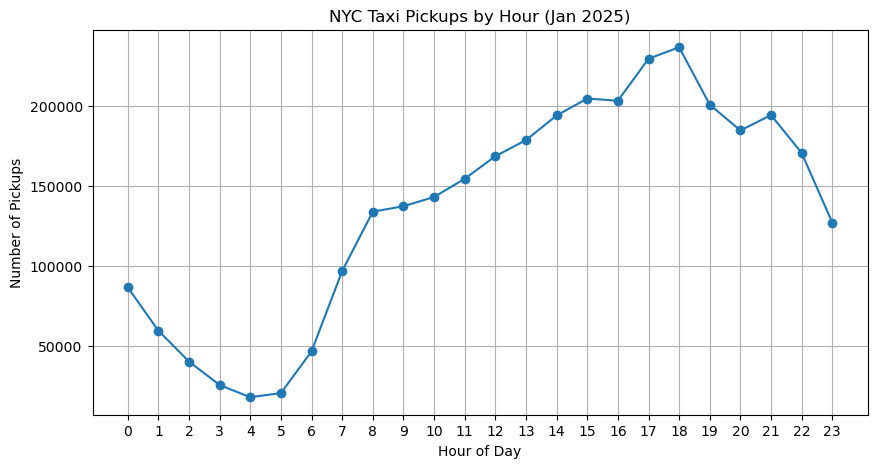

In [43]:
# Plot: Pickups by hour
plt.figure(figsize=(10, 5))
plt.plot(pickup_pd["hour"], pickup_pd["count"], marker='o')
plt.title("NYC Taxi Pickups by Hour (Jan 2025)")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Pickups")
plt.grid(True)
plt.xticks(range(0, 24))
plt.show()

#### Geospatial Analysis with Apache Spark

Objective:
- Identify popular pickup zones.

- Visualize demand hotspots in NYC.

- Optionally, export data for map visualization (e.g., with Folium or GeoPandas).



In [44]:
zone_df = spark.read.csv("data/taxi_zone_lookup.csv", header=True, inferSchema=True)

# Join with pickup zone
df = df.join(zone_df, df.PULocationID == zone_df.LocationID, "left") \
       .withColumnRenamed("Borough", "pickup_borough") \
       .withColumnRenamed("Zone", "pickup_zone") \
       .drop("service_zone", "LocationID")


In [45]:
pickup_counts = df.groupBy("pickup_borough", "pickup_zone") \
                  .count() \
                  .orderBy("count", ascending=False)

pickup_counts.show(10, truncate=False)


+--------------+----------------------------+------+
|pickup_borough|pickup_zone                 |count |
+--------------+----------------------------+------+
|Manhattan     |Midtown Center              |161414|
|Manhattan     |Upper East Side South       |158098|
|Manhattan     |Upper East Side North       |149839|
|Queens        |JFK Airport                 |134836|
|Manhattan     |Times Sq/Theatre District   |118268|
|Manhattan     |Penn Station/Madison Sq West|114142|
|Manhattan     |Midtown East                |112640|
|Manhattan     |Lincoln Square East         |106057|
|Manhattan     |Upper West Side South       |91914 |
|Manhattan     |Midtown North               |91567 |
+--------------+----------------------------+------+
only showing top 10 rows



In [46]:
pickup_pd = pickup_counts.toPandas()
pickup_pd.to_csv("output/popular_pickup_zones.csv", index=False)


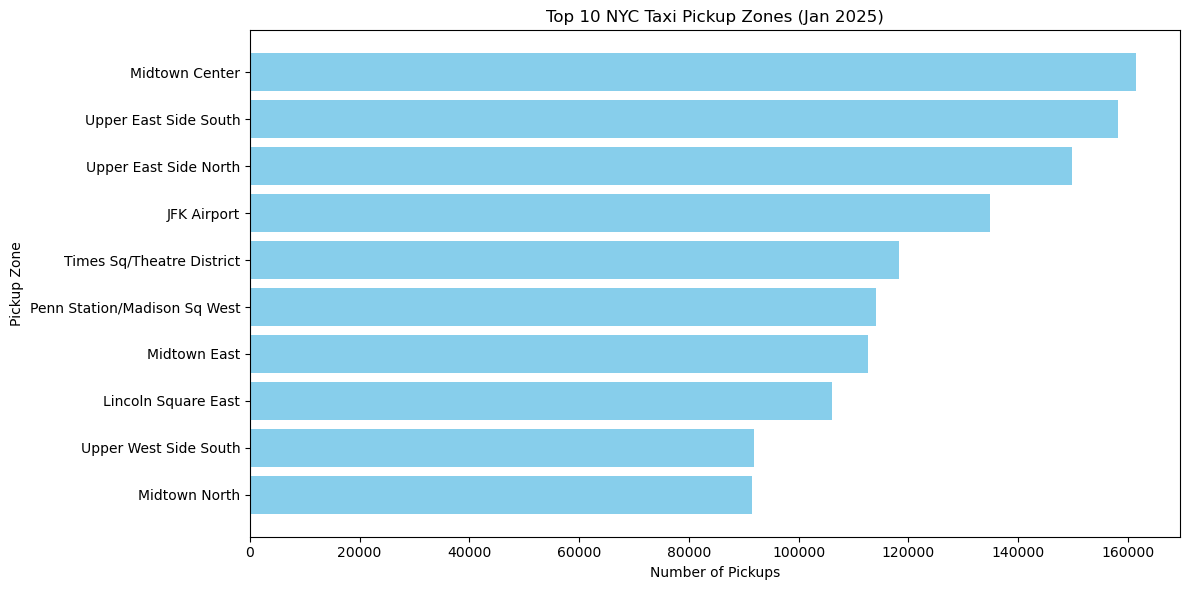

In [47]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV you exported from Spark
df2 = pd.read_csv("output/popular_pickup_zones.csv")

# Get top 10 zones
top10 = df2.sort_values(by="count", ascending=False).head(10)

# Plot
plt.figure(figsize=(12, 6))
plt.barh(top10["pickup_zone"], top10["count"], color="skyblue")
plt.xlabel("Number of Pickups")
plt.ylabel("Pickup Zone")
plt.title("Top 10 NYC Taxi Pickup Zones (Jan 2025)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [30]:
!pip install geopandas -q

In [50]:
# Group pickup counts by location
pickup_by_zone = df.groupBy("PULocationID").count()

# Convert to Pandas
pickup_pd = pickup_by_zone.toPandas()


In [51]:
# Load shapefile
gdf = gpd.read_file("data/taxi_zones/taxi_zones.shp")

# Merge on LocationID
merged = gdf.merge(pickup_pd, left_on="LocationID", right_on="PULocationID")


<Figure size 1200x1000 with 0 Axes>

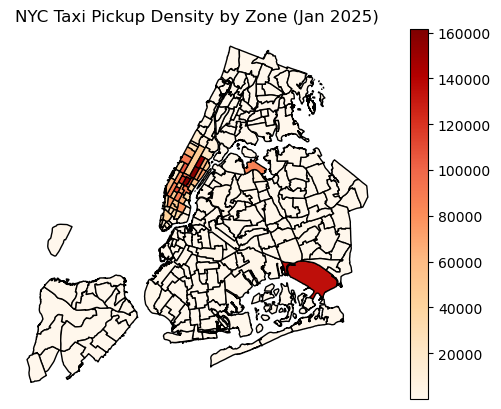

In [52]:
plt.figure(figsize=(12, 10))
merged.plot(column="count", cmap="OrRd", legend=True, edgecolor="black")
plt.title("NYC Taxi Pickup Density by Zone (Jan 2025)")
plt.axis("off")
plt.show()
